In [1]:

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from pathlib import Path

import sys
sys.path.append("/home/rufael.marew/Documents/projects/tau/Fingers-Gesture-Recognition")
import Source.fgr.models as models
from Source.fgr.pipelines import Data_Pipeline
from Source.fgr.data_manager import Data_Manager

import torch
from torch import nn
import torch.nn.functional as functional

from sklearn.manifold import TSNE
import seaborn as sns

sys.path.append("/home/rufael.marew/Documents/projects/tau/Domain_Adaptation_For_EMG")
from models import Net, vision
import os



/home/rufael.marew/.conda/envs/tau/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
## Directories
DATA_DIR = '../../data/'
FIG_DIR = '../../figures/'

Path(FIG_DIR).mkdir(parents=True, exist_ok=True)

In [3]:
# pipeline definition and data manager creation
data_path = Path(DATA_DIR+'doi_10')
pipeline = Data_Pipeline(base_data_files_path=data_path)  # configure the data pipeline you would like to use (check pipelines module for more info)
subject = 1
dm = Data_Manager([subject], pipeline)
print(dm.data_info())

dataset = dm.get_dataset(experiments=[f'{subject:03d}_1_1'])
data = dataset[0]
labels = dataset[1]

labels = np.char.strip(labels, '_0123456789')
data = data.reshape(data.shape[0],4,4)
data.shape

Available experiments in the data manager: ['001_1_3', '001_1_2', '001_2_1', '001_2_3', '001_1_1', '001_2_2']
Experiments format is: subject_session_position
None
Experiments in datasets: ['001_1_1']
Starting to extract datasets


Loading experiments datasets:   0%|          | 0/1 [00:00<?, ?exp/s]

Error: annotation mismatch, no Release/End annotation for Recording ed in time: 0.862, in the experiment: 001_1_1


Loading experiments datasets: 100%|██████████| 1/1 [00:08<00:00,  8.95s/exp]

finished extracting the dataset


(2521, 4, 4)

[508, 656, 633, 543, 509, 458, 638, 629, 478, 589]


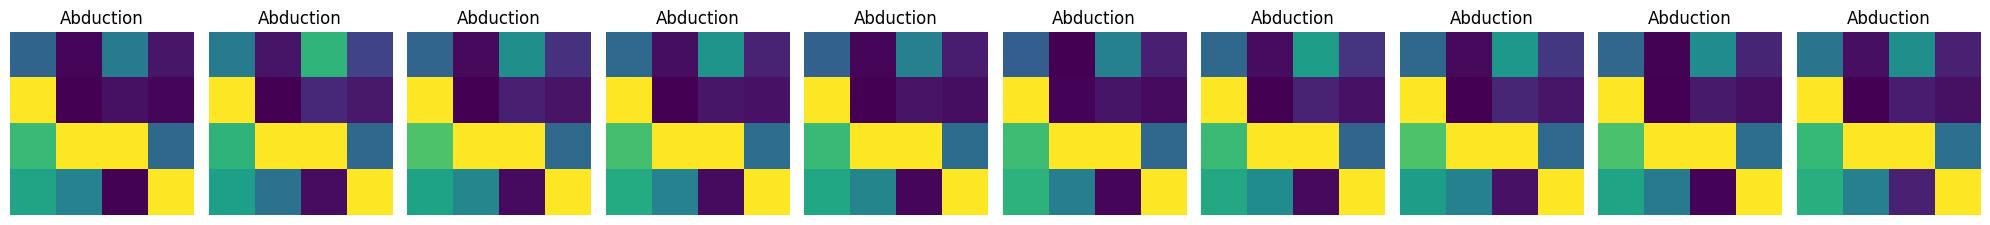

[1123, 1088, 1140, 899, 905, 1088, 1005, 1008, 991, 1119]


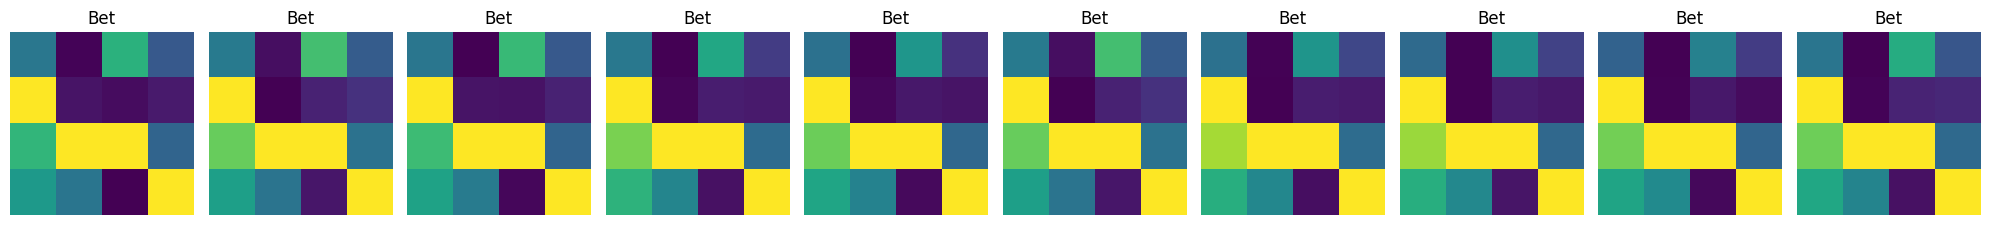

[721, 713, 743, 701, 689, 673, 777, 756, 805, 799]


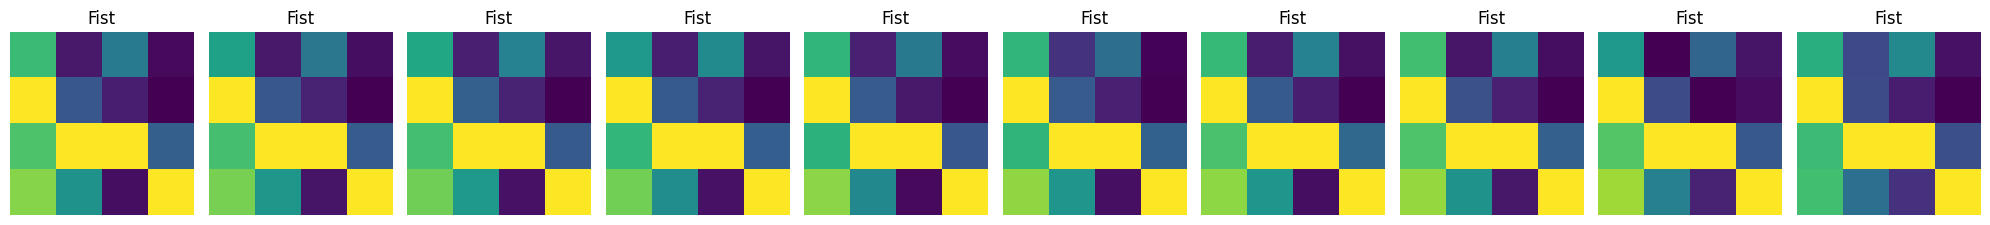

[1418, 1397, 1392, 1302, 1323, 1187, 1183, 1246, 1206, 1368]


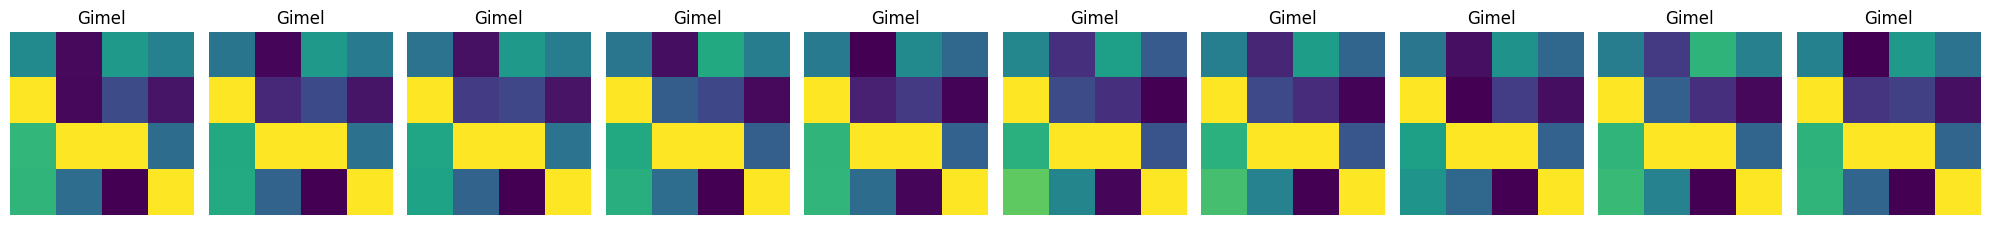

[1488, 1493, 1640, 1529, 1635, 1457, 1451, 1460, 1528, 1450]


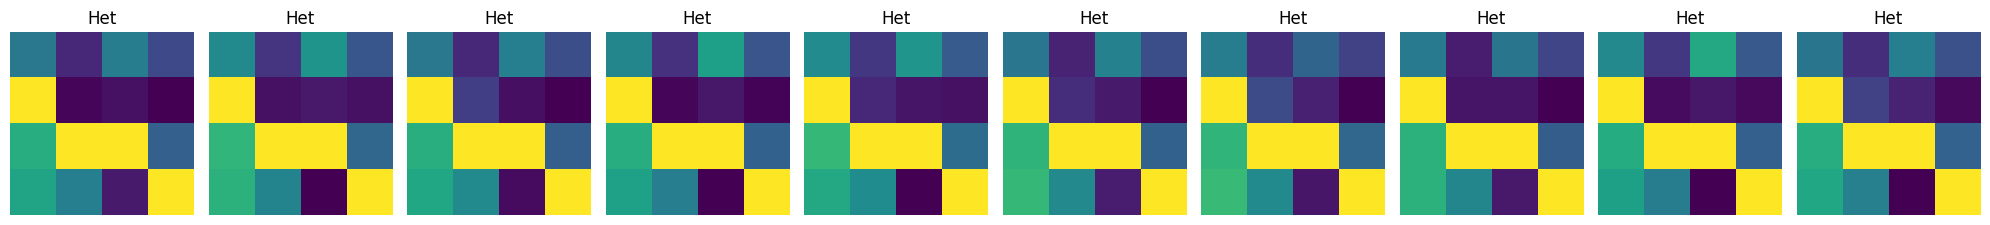

[2090, 2107, 2027, 2013, 1951, 2061, 1993, 2017, 2166, 2051]


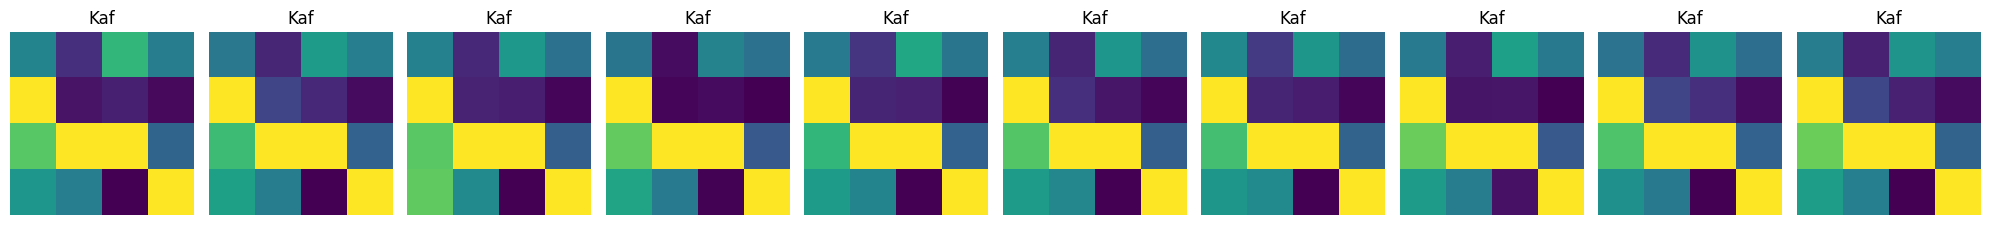

[2348, 2312, 2370, 2489, 2416, 2394, 2437, 2415, 2410, 2447]


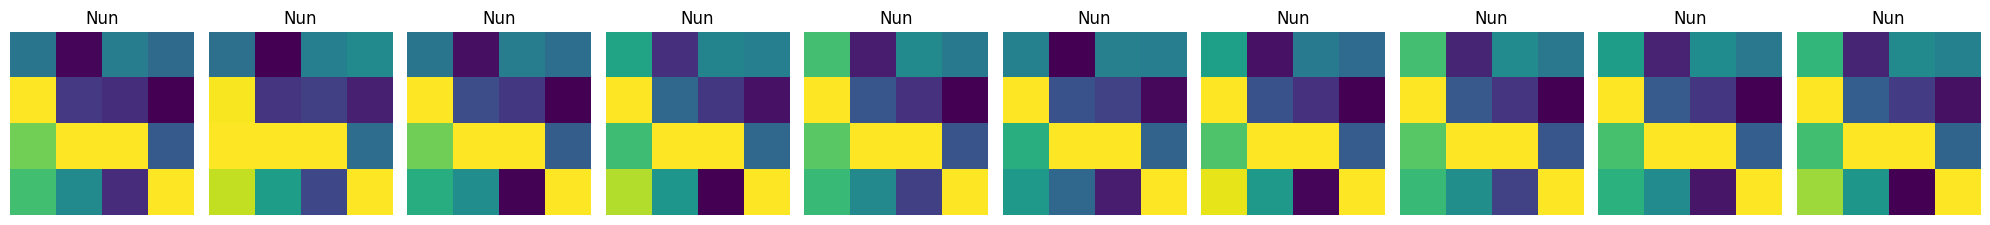

[1904, 1784, 1910, 1812, 1859, 1817, 1837, 1708, 1694, 1745]


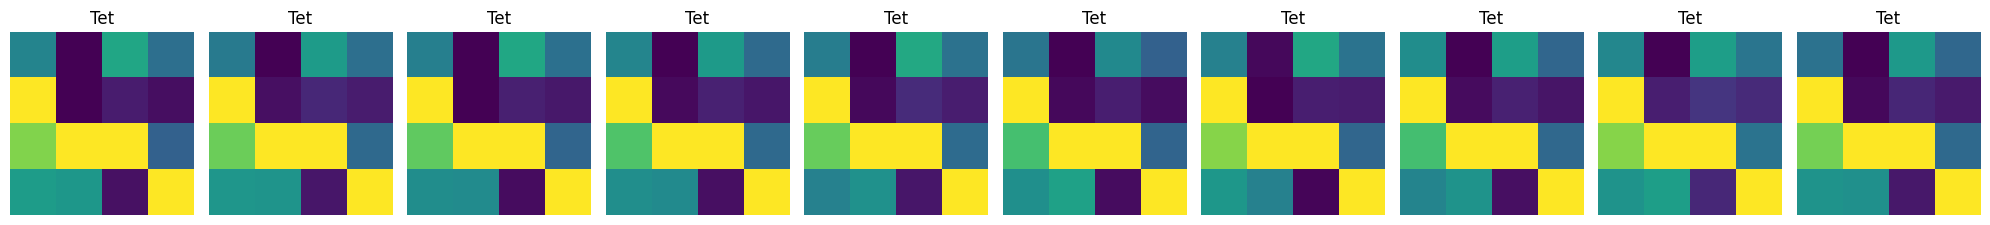

[265, 256, 369, 440, 233, 388, 290, 235, 273, 390]


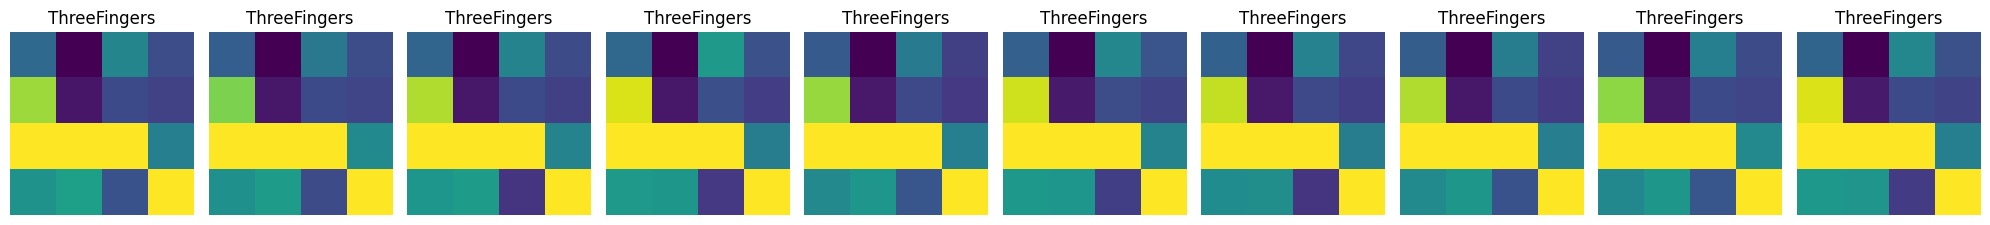

[169, 164, 196, 194, 207, 163, 144, 97, 47, 187]


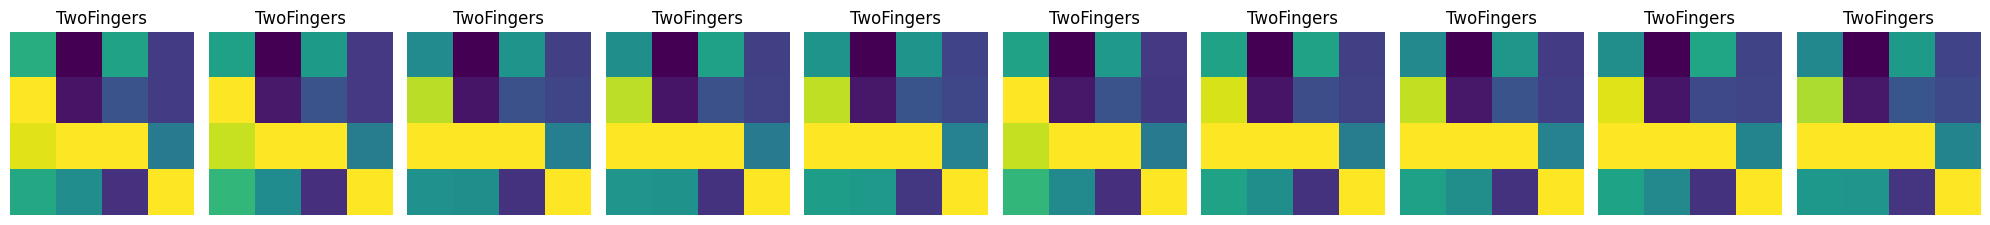

In [4]:
from random import randint, choices
# visualize 10 images from each class
for i in np.unique(labels):
    sample = choices([j for j in range(len(labels)) if labels[j] == i], k=10)
    print(sample)
    #create figure with subplots with figsize
    fig, axes = plt.subplots(nrows=1, ncols=10, figsize=(20, 4))
    
    for index, k in enumerate(sample):
        axes[index].imshow(data[k])
        axes[index].set_title(labels[k])
        axes[index].axis('off')
    #remove axis
    
    plt.tight_layout()
    plt.show()
    

In [5]:
class emgData:
    def __init__(self, data_manager, subjects):
        self.dm = data_manager
        self.subject = subjects
        self.tsne = TSNE(n_components=2, random_state=0)

    def get_data_by_subject(self, subject, pos=1):
        data = []
        label_pos = []
        label_gest = []
        label_subject = []
        label = []
        
        for i in subject:
            if isinstance(pos, list):
                dataset = self.dm.get_dataset(experiments=[f'{i:03d}_1_{j}' for j in pos])
            else:
                dataset = self.dm.get_dataset(experiments=[f'{i:03d}_1_{pos}'])
            
            data.append(dataset[0].reshape(dataset[0].shape[0],4,4))
            label_pos.append( np.array([i.split('_')[2] for i in dataset[1]]))
            label_gest.append(np.array([i.split('_')[3] for i in dataset[1]]))
            label_subject.append(np.array([str(i) for n in range(len(dataset[1]))]))
            label.append(np.array(['_'.join(i.split('_')[::-1][1:3]) for i in dataset[1]]))
        
        #use tsne to reduce features
        data = np.concatenate(data, axis=0)
        label_pos = np.concatenate(label_pos, axis=0)
        label_gest = np.concatenate(label_gest, axis=0)
        label_subject = np.concatenate(label_subject, axis=0)
        label = np.concatenate(label, axis=0)


        data_reduced = self.tsne.fit_transform(data.reshape(data.shape[0],-1))

        return data, label_pos, label_gest, label_subject, label, data_reduced

    
    def get_data_by_pos(self, pos=[1,2,3], subject=1):
        
        dataset = self.dm.get_dataset(experiments=[f'{subject:03d}_1_{i}' for i in pos])
        data = dataset[0].reshape(dataset[0].shape[0],4,4)
        label_pos = np.array([i.split('_')[2] for i in dataset[1]])
        label_gest = np.array([i.split('_')[3] for i in dataset[1]])
        label_subject = np.array([subject for j in range(len(dataset[1]))])
        label = np.array(['_'.join(i.split('_')[::-1][1:3]) for i in dataset[1]])

        data_reduced = self.tsne.fit_transform(data.reshape(data.shape[0],-1))

        return data, label_pos, label_gest, label_subject, label, data_reduced
        
    

In [6]:
def extract_feat(data, model=None, device=None):
    if model == None:
        features = data.reshape(data.shape[0], 16)
        return features

    model = model.to(device)
    data = torch.from_numpy(data).float()
    data = data.reshape(data.shape[0], 1, 4, 4).to(device)
    features = model(data,feat=True)
    
    return features.cpu().detach().numpy()

In [7]:
from sklearn.preprocessing import MinMaxScaler

def plot_tsne(X_2d, labels, title):
    # if tsne is None:
    #     tsne = TSNE(n_components=2, random_state=0)
    #     X_2d = tsne.fit_transform(features)
    # else:
    #     X_2d = tsne.transform(features)
    # scaler = MinMaxScaler()
    # X_2d = scaler.fit_transform(X_2d)

    target_ids = range(len(np.unique(labels)))
    target_names = np.unique(labels)
    colors = sns.color_palette("hls", len(target_names))

    plt.figure(figsize=(6, 10))
    for i, c, label in zip(target_ids, colors, target_names):
        plt.scatter(X_2d[labels == label, 0], X_2d[labels == label, 1], c=c, label=label)
    plt.legend()
    plt.title(title)

    plt.savefig(os.path.join(FIG_DIR,title+".png"))
    plt.show()

In [8]:
def plot_tsne_gestures(X_2d, y,labels,labels_gest, title="tsne plot"):
    

    to_plot = [i for i in range(len(y)) if labels_gest[i] in labels]
    y_to_plot = y[to_plot]
    target_names = np.unique(y_to_plot)
    print("Number of samples to plot: ", len(to_plot))
    print("Number of classes to plot: ", np.unique(y_to_plot))
    target_ids = range(len(np.unique(y_to_plot)))
    colors = sns.color_palette("hls", len(target_names))

    # tsne = TSNE(n_components=2, random_state=0)
    # X_2d = tsne.fit_transform(X[to_plot])
    # scaler = MinMaxScaler()
    # X_2d = scaler.fit_transform(X_2d)
    
    X_2d = X_2d[to_plot]

    fig, ax = plt.subplots(figsize=(6, 10))
    for i, c, label in zip(target_ids, colors, target_names):
        ax.scatter(X_2d[y_to_plot == label, 0], X_2d[y_to_plot == label, 1], c=c, label=label)

    pos = ax.get_position()
    ax.set_position([pos.x0, pos.y0, pos.width * 1.5, pos.height])
    ax.legend(loc='center right', bbox_to_anchor=(1.25, 0.5))
    ax.set_xticks(np.arange(-100, 100, 25))
    ax.set_yticks(np.arange(-100, 100, 25))
    # plt.legend()
    plt.title(title)

    plt.savefig(os.path.join(FIG_DIR,title+".png"))
    plt.show()
    

### Vizualization for a single subject

In [9]:
# pipeline definition and data manager creation
data_path = Path(DATA_DIR+'doi_10')
pipeline = Data_Pipeline(base_data_files_path=data_path)  # configure the data pipeline you would like to use (check pipelines module for more info)
subject = [1]
dm = Data_Manager(subject, pipeline)
emgdata = emgData(dm, subject)


In [10]:
data, label_pos, labels_gest, label_sub, label, data_reduced = emgdata.get_data_by_subject(subject, 1)

Experiments in datasets: ['001_1_1']
Starting to extract datasets


Loading experiments datasets:   0%|          | 0/1 [00:00<?, ?exp/s]

Error: annotation mismatch, no Release/End annotation for Recording ed in time: 0.862, in the experiment: 001_1_1


Loading experiments datasets: 100%|██████████| 1/1 [00:08<00:00,  8.97s/exp]


finished extracting the dataset


/tmp/ipykernel_1531469/2942983537.py:18: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(X_2d[labels == label, 0], X_2d[labels == label, 1], c=c, label=label)


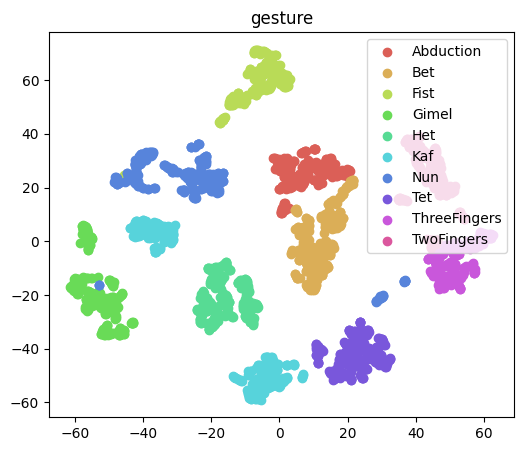

In [11]:
# features = extract_feat(data)
plot_tsne(data_reduced, labels_gest, title='gesture')

#### Plot by position

In [12]:
data, label_pos, labels_gest, label_sub, label, data_reduced = emgdata.get_data_by_pos()
# features = extract_feat(data_reduced)

# data.shape

Experiments in datasets: ['001_1_3', '001_1_2', '001_1_1']
Starting to extract datasets


Loading experiments datasets:   0%|          | 0/3 [00:00<?, ?exp/s]

Error: annotation mismatch, no Release/End annotation for Recording ed in time: 0.071, in the experiment: 001_1_3


Loading experiments datasets:  33%|███▎      | 1/3 [00:07<00:15,  7.73s/exp]

Error: annotation mismatch, no Release/End annotation for Recording ed in time: 0.224, in the experiment: 001_1_2


Loading experiments datasets: 100%|██████████| 3/3 [00:16<00:00,  5.59s/exp]


finished extracting the dataset


### Plot pos

/tmp/ipykernel_1531469/2942983537.py:18: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(X_2d[labels == label, 0], X_2d[labels == label, 1], c=c, label=label)


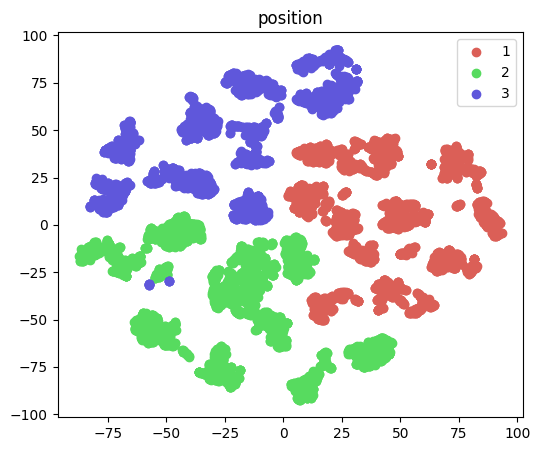

In [13]:
plot_tsne(data_reduced, label_pos, title="position")

/tmp/ipykernel_1531469/2942983537.py:18: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(X_2d[labels == label, 0], X_2d[labels == label, 1], c=c, label=label)


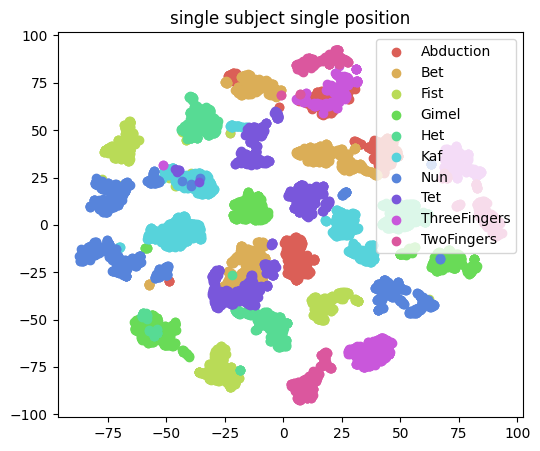

In [14]:
plot_tsne(data_reduced, labels_gest, title='single subject single position')

Number of samples to plot:  2837
Number of classes to plot:  ['Abduction_1' 'Abduction_2' 'Abduction_3' 'Bet_1' 'Bet_2' 'Bet_3'
 'Fist_1' 'Fist_2' 'Fist_3' 'Gimel_1' 'Gimel_2' 'Gimel_3']


/tmp/ipykernel_1531469/719437150.py:21: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(X_2d[y_to_plot == label, 0], X_2d[y_to_plot == label, 1], c=c, label=label)


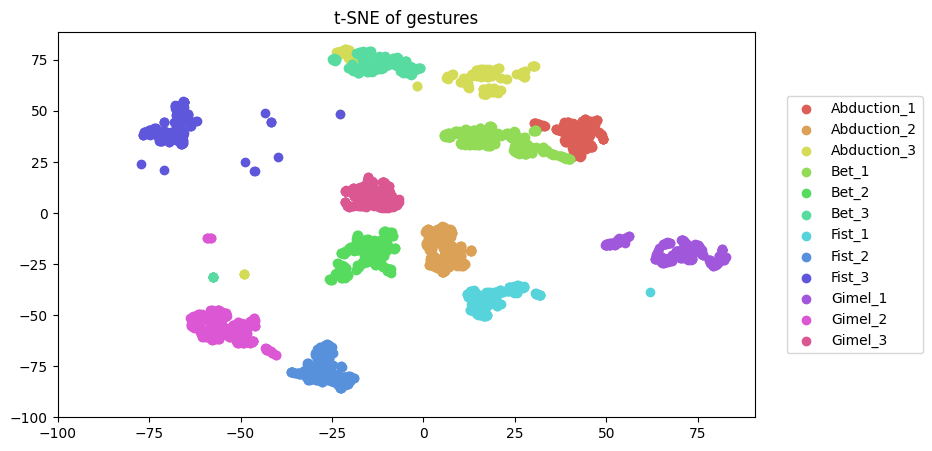

In [17]:
plot_tsne_gestures(data_reduced, label,np.unique(labels_gest).tolist()[:4] ,labels_gest=labels_gest, title='t-SNE of gestures')

In [18]:
model = Net()
#load the model
model.load_state_dict(torch.load('../outputs/model_cnn.pt'))

#setup device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")




In [19]:
features = extract_feat(data, model, device)

/home/rufael.marew/.conda/envs/tau/lib/python3.10/site-packages/torch/nn/modules/conv.py:459: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ../aten/src/ATen/native/Convolution.cpp:1003.)
  return F.conv2d(input, weight, bias, self.stride,


In [20]:
tsne = TSNE(n_components=2, random_state=0)
x2d = tsne.fit_transform(features)

Number of samples to plot:  2837
Number of classes to plot:  ['Abduction_1' 'Abduction_2' 'Abduction_3' 'Bet_1' 'Bet_2' 'Bet_3'
 'Fist_1' 'Fist_2' 'Fist_3' 'Gimel_1' 'Gimel_2' 'Gimel_3']


/tmp/ipykernel_1531469/719437150.py:21: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(X_2d[y_to_plot == label, 0], X_2d[y_to_plot == label, 1], c=c, label=label)


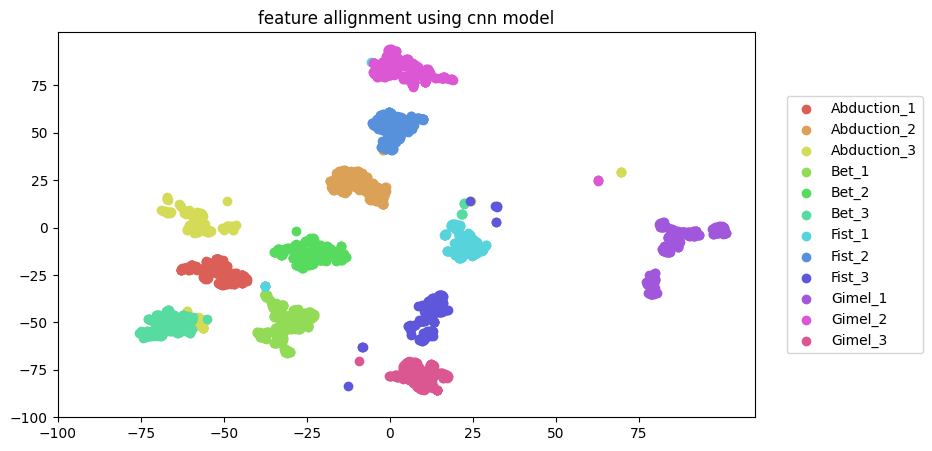

In [21]:
plot_tsne_gestures(x2d, label,np.unique(labels_gest).tolist()[:4] ,labels_gest=labels_gest, title='feature allignment using cnn model')

In [22]:
model = vision(image_size=4, 
                    patch_size=2, 
                    num_classes=10, 
                    hidden_dim=64, 
                    num_layers=1, num_heads=2, mlp_dim=40, attention_dropout=0.1).to(device)

In [23]:
#load model
model.load_state_dict(torch.load('../outputs/model_vit.pt'))


RuntimeError: Error(s) in loading state_dict for vision:
	Missing key(s) in state_dict: "class_token", "conv_proj.weight", "conv_proj.bias", "encoder.pos_embedding", "encoder.layers.encoder_layer_0.ln_1.weight", "encoder.layers.encoder_layer_0.ln_1.bias", "encoder.layers.encoder_layer_0.self_attention.in_proj_weight", "encoder.layers.encoder_layer_0.self_attention.in_proj_bias", "encoder.layers.encoder_layer_0.self_attention.out_proj.weight", "encoder.layers.encoder_layer_0.self_attention.out_proj.bias", "encoder.layers.encoder_layer_0.ln_2.weight", "encoder.layers.encoder_layer_0.ln_2.bias", "encoder.layers.encoder_layer_0.mlp.0.weight", "encoder.layers.encoder_layer_0.mlp.0.bias", "encoder.layers.encoder_layer_0.mlp.3.weight", "encoder.layers.encoder_layer_0.mlp.3.bias", "encoder.ln.weight", "encoder.ln.bias", "heads.head.weight", "heads.head.bias". 
	Unexpected key(s) in state_dict: "conv_1.weight", "conv_1.bias", "batch_norm_1.weight", "batch_norm_1.bias", "batch_norm_1.running_mean", "batch_norm_1.running_var", "batch_norm_1.num_batches_tracked", "conv_2.weight", "conv_2.bias", "batch_norm_2.weight", "batch_norm_2.bias", "batch_norm_2.running_mean", "batch_norm_2.running_var", "batch_norm_2.num_batches_tracked", "fc_1.weight", "fc_1.bias", "batch_norm_3.weight", "batch_norm_3.bias", "batch_norm_3.running_mean", "batch_norm_3.running_var", "batch_norm_3.num_batches_tracked", "fc_2.weight", "fc_2.bias", "batch_norm_4.weight", "batch_norm_4.bias", "batch_norm_4.running_mean", "batch_norm_4.running_var", "batch_norm_4.num_batches_tracked", "fc_3.weight", "fc_3.bias". 

In [50]:
#remove the classification head from the model
model.heads = nn.Identity()
model


vision(
  (conv_proj): Conv2d(1, 64, kernel_size=(2, 2), stride=(2, 2))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((64,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((64,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=64, out_features=40, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=40, out_features=64, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
    )
    (ln): LayerNorm((64,), eps=1e-06, elementwise_affine=True)
  )
  (heads): Identity()
)

In [51]:
#dumy data
features = extract_feat(data, model, device)


Number of samples to plot:  2088
Number of classes to plot:  ['1_Abduction' '1_Bet' '1_Fist' '2_Abduction' '2_Bet' '2_Fist'
 '3_Abduction' '3_Bet' '3_Fist']


/tmp/ipykernel_1680230/1583220242.py:20: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(X_2d[y_to_plot == label, 0], X_2d[y_to_plot == label, 1], c=c, label=label)


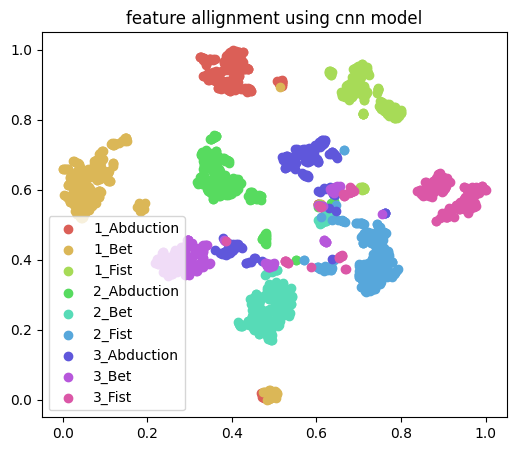

In [52]:
plot_tsne_gestures(features, label,np.unique(labels_gest).tolist()[:3] ,labels_gest=labels_gest, title='feature allignment using cnn model')